In [1]:
"""

This project will pull data from three seperate csv files and two seperate sources.

Firstly, the EMNIST dataset (https://www.kaggle.com/crawford/emnist) will supply both a set of 156k letters (6k per upper/lowercase pair) and 60k digits (6k / digit).
Unfortuanently the EMNIST dataset, when extracted into a .npy format, both needs to be rotated by 270* and flipped allong its y axis.  This is done durring the pre-processing phase

Secondly, the Handwritten math symbols dataset (https://www.kaggle.com/xainano/handwrittenmathsymbols) will supply 66k images of mathematical symbols (6k / symbol).

All in all this project will have 46 classifications (26 letters, 10 digits, 10 symbols), all of which will be of size 28x28x1

"""

'\n\nThis project will pull data from three seperate csv files and two seperate sources.\n\nFirstly, the EMNIST dataset (https://www.kaggle.com/crawford/emnist) will supply both a set of 156k letters (6k per upper/lowercase pair) and 60k digits (6k / digit).\nUnfortuanently the EMNIST dataset, when extracted into a .npy format, both needs to be rotated by 270* and flipped allong its y axis.  This is done durring the pre-processing phase\n\nSecondly, the Handwritten math symbols dataset (https://www.kaggle.com/xainano/handwrittenmathsymbols) will supply 66k images of mathematical symbols (6k / symbol).\n\nAll in all this project will have 46 classifications (26 letters, 10 digits, 10 symbols), all of which will be of size 28x28x1\n\n'

In [2]:
#? load libraries
from IPython.display import display

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageEnhance, ImageOps
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
#? base data storage variables
SAMPLES_PER_CLASS = 3000

(26, 3000, 784)


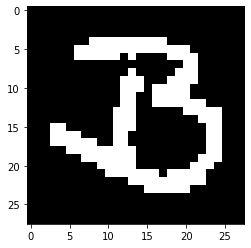

In [4]:
#? load 3k images from each item in the alphabetic csv
ALPHABETIC_PATH = 'D:/Datasets/EMNIST/emnist-letters-train.csv'
a_data = pd.read_csv(ALPHABETIC_PATH)

# extract lables for safekeeping
a_lables = a_data.to_numpy()[:, 0] - 1 # need to subtract 1 becayse labels go from 1-26

# rotate the images by 270* and then flip it on the Y axis
a_data_npy = a_data.to_numpy()[:, 1:]
a_data_npy = a_data_npy.reshape((-1, 28, 28, 1))
a_data_npy = np.rot90(np.flip(a_data_npy, axis=2), k=1, axes=(1, 2))
a_data_npy = a_data_npy.reshape((-1, 784))

# binarize the data
THRESHOLD = 140
a_data_npy = np.where(a_data_npy < THRESHOLD, 0, 1)

# sort out and remove all but the first [SAMPLES_PER_CLASS] occurances of each class
a_balanced_data = [[] for _ in range(26)]
a_class_frequency = [0] * 26
for i in range(a_data_npy.shape[0]):
    c = a_lables[i]

    if a_class_frequency[c] < SAMPLES_PER_CLASS:
        a_class_frequency[c] += 1
        a_balanced_data[c].append(a_data_npy[i])

a_balanced_data_npy = np.asarray(a_balanced_data)

print(a_balanced_data_npy.shape)
plt.imshow(a_balanced_data_npy[1, 0].reshape((28, 28)), 'gray')
plt.show()

(10, 3000, 784)


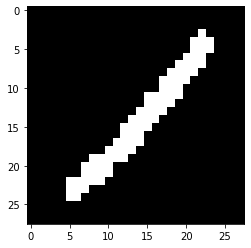

In [5]:
#? load 3k images from each item in the numeric csv
NUMERIC_PATH = 'D:/Datasets/EMNIST/emnist-digits-train.csv'
n_data = pd.read_csv(NUMERIC_PATH)

# extract lables for safekeeping
n_lables = n_data.to_numpy()[:, 0]

# rotate the images by 270* and then flip it on the Y axis
n_data_npy = n_data.to_numpy()[:, 1:]
n_data_npy = n_data_npy.reshape((-1, 28, 28, 1))
n_data_npy = np.rot90(np.flip(n_data_npy, axis=2), k=1, axes=(1, 2))
n_data_npy = n_data_npy.reshape((-1, 784))

# binarize the data
THRESHOLD = 140
n_data_npy = np.where(n_data_npy < THRESHOLD, 0, 1)

# sort out and remove all but the first [SAMPLES_PER_CLASS] occurances of each class
n_balanced_data = [[] for _ in range(10)]
n_class_frequency = [0] * 10

for i in range(n_data_npy.shape[0]):
    c = n_lables[i]

    if n_class_frequency[c] < SAMPLES_PER_CLASS:
        n_class_frequency[c] += 1

        n_balanced_data[c].append(n_data_npy[i])

# convert to npy
n_balanced_data_npy = np.asarray(n_balanced_data)

print(n_balanced_data_npy.shape)
plt.imshow(n_balanced_data_npy[1, 0].reshape((28, 28)), 'gray')
plt.show()

In [6]:
"""
#? load the symbolic data from the Handwritten math symbols dataset.  This data was downloaded as a collection of images sorted into names directories
SYMBOL_PATH = 'C:/Users/trebo/Downloads/Mathematical Symbols'

m_balanced_data = []
m_class_frequency = [0] * 10

# loop over each image in each directory
lable = 0

for dir in os.listdir(SYMBOL_PATH):
    dir_path = os.path.join(SYMBOL_PATH, dir)

    m_data = []

    for file in os.listdir(dir_path):
        # load the image as a greyscale jpg
        img_path = os.path.join(dir_path, file)
        img = Image.open(img_path).convert('L')

        # note: image is blurred and contrasted to increase it's line width.  The handwritten math symbols dataset contains both thinner digits and larger resolutions so detail is lost when reducting the resolution to 28x28.  This process reduces this loss in detail

        # apply a blur filter to the image, shrink it down, and up its contrast
        img = img.filter(ImageFilter.GaussianBlur(2)).resize((24, 24))
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(8)

        # add padding to the image to make it fit in with the other images
        img = ImageOps.expand(img, border=2, fill='white')

        # convert the image to a npy, invert it, up its contrast, and binarize it
        img_npy = np.asarray(img).reshape((784))
        img_npy = 255 - img_npy

        THRESHOLD = 140
        img_npy = np.where(img_npy < THRESHOLD, 0, 1)

        # add it to the array of unformated data and increment the class counter
        m_data.append(img_npy)
        m_class_frequency[lable] += 1
        
        # stop collecting images if there are enough
        if (m_class_frequency[lable] >= SAMPLES_PER_CLASS):
            break
    
    # if we're done looping through the images and don't have [SAMPLES_PER_CLASS] yet then augment the data
    if (m_class_frequency[lable] < SAMPLES_PER_CLASS):
        print(f'Augmenting data for class {dir}')

        datagen = ImageDataGenerator(
            rotation_range=0,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=False
        )

        augmentable_data = np.asarray(m_data)[:, :].reshape((-1, 28, 28, 1))

        for batch in datagen.flow(augmentable_data, batch_size=1):

            # binarize the new image and add it to the data
            THRESHOLD = 100
            augmented_img = (batch * 255) / batch.max()
            augmented_img = np.where(augmented_img < THRESHOLD, 0, 1)
            augmented_img = augmented_img.reshape(784)

            m_class_frequency[lable] += 1
            m_data.append(augmented_img)

            # stop generating more images when it's no longer necisary
            if (m_class_frequency[lable] >= SAMPLES_PER_CLASS):
                break
        
    # convert the data to a npy and append it to the data array
    m_data_npy = np.asarray(m_data)
    m_balanced_data.append(m_data_npy)

    # increment the lable counter
    lable += 1

# convert the list of balanced data into a npy
m_balanced_data_npy = np.asarray(m_balanced_data)
print(f'\n{m_balanced_data_npy.shape}')
plt.imshow(m_balanced_data_npy[1, 0].reshape(28, 28), 'gray')
plt.show()
"""

"\n#? load the symbolic data from the Handwritten math symbols dataset.  This data was downloaded as a collection of images sorted into names directories\nSYMBOL_PATH = 'C:/Users/trebo/Downloads/Mathematical Symbols'\n\nm_balanced_data = []\nm_class_frequency = [0] * 10\n\n# loop over each image in each directory\nlable = 0\n\nfor dir in os.listdir(SYMBOL_PATH):\n    dir_path = os.path.join(SYMBOL_PATH, dir)\n\n    m_data = []\n\n    for file in os.listdir(dir_path):\n        # load the image as a greyscale jpg\n        img_path = os.path.join(dir_path, file)\n        img = Image.open(img_path).convert('L')\n\n        # note: image is blurred and contrasted to increase it's line width.  The handwritten math symbols dataset contains both thinner digits and larger resolutions so detail is lost when reducting the resolution to 28x28.  This process reduces this loss in detail\n\n        # apply a blur filter to the image, shrink it down, and up its contrast\n        img = img.filter(ImageF

In [7]:
#? create a lable dictionary
# lables are in ASCII and can be decoded with the chr() function
LABEL_DIRECTORY = './dataset-mapping-emnist.txt'

label_map = pd.read_csv(LABEL_DIRECTORY,
                        delimiter = ' ', 
                        index_col=0, 
                        header=None, 
                        squeeze=True)

label_dictionary = {}
for index, label in enumerate(label_map):
    label_dictionary[index] = chr(label)

print(label_dictionary)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: '0', 27: '1', 28: '2', 29: '3', 30: '4', 31: '5', 32: '6', 33: '7', 34: '8', 35: '9'}


In [10]:
# combine all the npy arrays into a single huge array
data = np.concatenate((a_balanced_data_npy, n_balanced_data_npy))
class_frequency = np.concatenate((a_class_frequency, n_class_frequency))
# data = np.concatenate((n_balanced_data_npy, m_balanced_data_npy))
# class_frequency = np.concatenate((n_class_frequency, m_class_frequency))

# normalize the dataset
# data =  data / 255

# slice out the letters 'O, L, I, X, Q, T' because they are too similar to to numbers / symbols
cleaned_data = data.copy()
"""
cleaned_data = np.delete(cleaned_data, 23, axis=0)
cleaned_data = np.delete(cleaned_data, 20, axis=0)
cleaned_data = np.delete(cleaned_data, 14, axis=0)
cleaned_data = np.delete(cleaned_data, 11, axis=0)
cleaned_data = np.delete(cleaned_data, 8, axis=0)
"""

print(cleaned_data.shape)

# save the dataset
np.save('./preprocessed_data_alphabetic_binarized.npy', cleaned_data)

# plot an image for each category
fig = plt.figure(figsize=(20, 20))

for i in range(36):
    fig.add_subplot(7, 7, i+1)
    plt.axis('off')
    plt.title(label_dictionary[i])
    plt.imshow(cleaned_data[i][0].reshape(28, 28), 'gray')
    plt.clim(0, 2)

plt.show()

(36, 3000, 784)


KeyError: 36